Graph with 21167 nodes and 60105 edges.


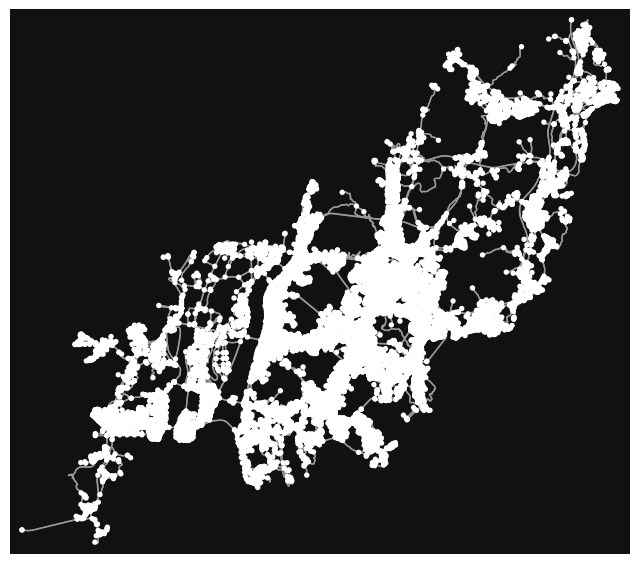

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
import osmnx as ox
import networkx as nx
import random
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops
import matplotlib.pyplot as plt
import numpy as np

# Step 1: 부산광역시 도로망 가져오기
def get_osm_network(place_name="Busan, South Korea"):
    G = ox.graph_from_place(place_name, network_type="drive")
    print(f"Graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

network = get_osm_network()

# 도로망 시각화
ox.plot_graph(network)


Dijkstra Path Distance: 15780.112000000003


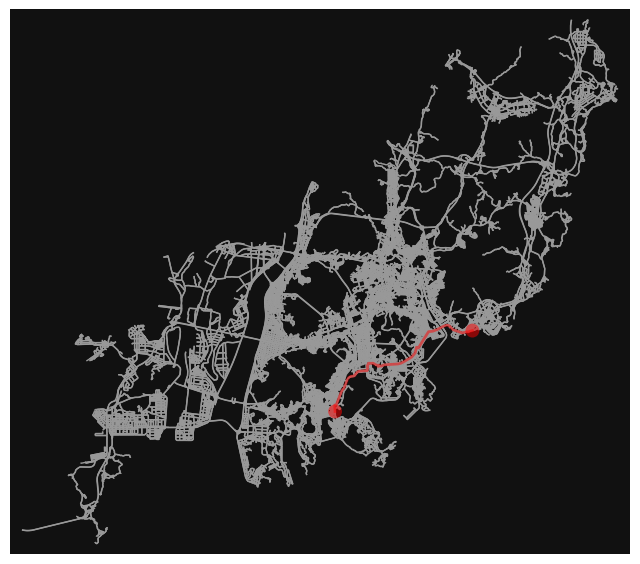

In [8]:

# Step 2: 전통적인 알고리즘으로 최단 경로 계산
def calculate_shortest_paths(G, source_node, target_node):
    # 다익스트라 알고리즘
    dijkstra_path = nx.shortest_path(G, source=source_node, target=target_node, weight="length")
    dijkstra_distance = nx.shortest_path_length(G, source=source_node, target=target_node, weight="length")
    return dijkstra_path, dijkstra_distance

# 노드 선택
start_coords = (35.1587, 129.1604)  # 해운대 근처
end_coords = (35.1009, 129.0408)    # 부산역 근처
start_node = ox.distance.nearest_nodes(network, start_coords[1], start_coords[0])
end_node = ox.distance.nearest_nodes(network, end_coords[1], end_coords[0])

# 다익스트라 결과
dijkstra_path, dijkstra_distance = calculate_shortest_paths(network, start_node, end_node)
print(f"Dijkstra Path Distance: {dijkstra_distance}")

# 경로 시각화
fig, ax = ox.plot_graph_route(network, dijkstra_path, route_color="red", route_linewidth=2, node_size=0)


In [13]:
from torch_geometric.utils import add_self_loops

def prepare_graph_data_fixed(G, dijkstra_path):
    # 노드와 엣지 데이터 준비
    G = nx.convert_node_labels_to_integers(G)  # 노드 인덱스를 정수로 변환
    edge_index = np.array(list(G.edges)).T  # Edge list 생성 (2, num_edges) 형식
    
    # 전치가 필요한 경우 처리
    if edge_index.shape[0] > 2:
        edge_index = edge_index.T

    # Debug: Edge index 크기 확인
    print(f"Edge index shape: {edge_index.shape}")
    print(f"Number of edges in graph: {G.number_of_edges()}")

    # 노드 특성 (더미 특성)
    node_features = np.ones((G.number_of_nodes(), 1))  # 노드당 1차원 특성
    labels = np.zeros((G.number_of_nodes(),))  # 최단 경로 여부 (0 또는 1)

    # 다익스트라 경로를 기반으로 레이블 생성
    for node in dijkstra_path:
        if node < len(labels):  # 유효한 노드 인덱스만 처리
            labels[node] = 1

    # PyTorch Geometric 데이터 생성
    data = Data(
        x=torch.tensor(node_features, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        y=torch.tensor(labels, dtype=torch.float),
    )

    # Self-loop 추가
    num_nodes = data.x.size(0)  # 정확한 노드 수 확인
    print(f"Number of nodes: {num_nodes}")  # Debug: 노드 수 확인

    # Self-loop 추가
    data.edge_index, _ = add_self_loops(data.edge_index, num_nodes=num_nodes)
    print(f"Edge index shape after self-loops: {data.edge_index.shape}")  # Debug: Self-loop 추가 후 크기 확인

    return data

# 그래프 데이터 준비
data = prepare_graph_data_fixed(network, dijkstra_path)

Edge index shape: (60105, 3)
Number of edges in graph: 60105
Number of nodes: 21167


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 60105 but got size 2 for tensor number 1 in the list.

In [ ]:

# Step 4: GNN 모델 정의
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


In [ ]:

# Step 5: GNN 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(input_dim=1, hidden_dim=16, output_dim=1).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

# 학습 루프
def train_gnn(model, data, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index).squeeze()
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

train_gnn(model, data, optimizer, criterion)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 3 but got size 2 for tensor number 1 in the list.

In [ ]:

# Step 6: GNN 예측
model.eval()
predictions = model(data.x, data.edge_index).squeeze()
predicted_path = (predictions > 0.5).nonzero(as_tuple=True)[0].tolist()
print(f"GNN Predicted Path: {predicted_path}")


In [ ]:

# Step 7: 결과 비교 및 시각화
# 실제 최단 경로 시각화
fig, ax = ox.plot_graph_route(network, dijkstra_path, route_color="red", route_linewidth=2, node_size=0)
